In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.contrib.gp as gp
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import os
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.double)

In [27]:
mat = pd.read_csv('../VCI_NDMA.csv')
mat = np.array(mat)
county = mat[:,0]
year = mat[:,1]
month = mat[:,2]
VCI3M = mat[:,3]


In [77]:
all_ct = np.unique(county)
for i in range(np.size(all_ct)):
    print('Choose '+str(i)+' for: ',all_ct[i])
num_reg = int(input("Please select a region: "))
region = all_ct[num_reg]
print("You have choosen:", region)
use = (county == region)
Y = year[use][2:].astype(int)
M = month[use][2:].astype(int)
V = VCI3M[use][2:].astype(float)

Choose 0 for:  BARINGO
Choose 1 for:  EMBU
Choose 2 for:  Garissa
Choose 3 for:  Isiolo
Choose 4 for:  KILIFI
Choose 5 for:  KWALE
Choose 6 for:  Kajiado
Choose 7 for:  Kitui
Choose 8 for:  LAIKIPIA
Choose 9 for:  LAMU
Choose 10 for:  Makueni
Choose 11 for:  Mandera
Choose 12 for:  Marsabit
Choose 13 for:  Meru
Choose 14 for:  NAROK
Choose 15 for:  NYERI
Choose 16 for:  Samburu
Choose 17 for:  TURKANA
Choose 18 for:  TaitaTaveta
Choose 19 for:  TanaRiver
Choose 20 for:  Tharaka-Nithi
Choose 21 for:  WEST POKOT
Choose 22 for:  Wajir


Please select a region:  0


You have choosen: BARINGO


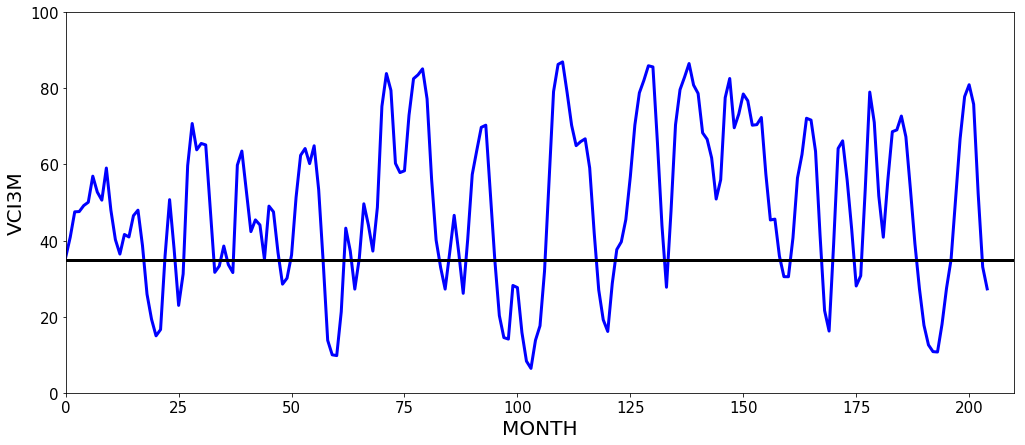

In [78]:
plt.figure(figsize=(17, 7))

X = np.arange(np.size(M))
plt.plot(X,V, linestyle = 'solid', lw = 3, color = 'blue')
plt.xlabel('MONTH', size = 20)
plt.ylabel('VCI3M', size = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(0,210)
plt.ylim(0,100)
plt.plot([0,800],[35,35],color = 'black', lw = 3)
plt.show()

In [99]:
k1 = gp.kernels.RBF(input_dim=2, lengthscale=torch.tensor(0.8),\
               variance = torch.tensor(2.5))
smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
pyro.enable_validation(True)       # can help with debugging
optim = Adam({"lr": 0.01}) 

pyro.clear_param_store()

plus_arr = np.max(X)+np.array([0.5,1,1.5,2,2.5])

X2 = (torch.from_numpy(X.astype(float)))
y2 = (torch.from_numpy(V-np.mean(V)))

Xtest_use = np.append(X.astype(float),plus_arr.astype(float))
                      
Xtest_use2 = (torch.from_numpy(Xtest_use))


gpr = gp.models.GPRegression(X2, y2,k1, noise=torch.tensor(0.01))

svi = SVI(gpr.model, gpr.guide, optim, loss=Trace_ELBO())
losses = []

num_steps = 500

for k in range(num_steps):
    losses.append(svi.step())

with torch.no_grad():
  if type(gpr) == gp.models.VariationalSparseGP:
    mean, cov = gpr(Xtest_use2, full_cov=True)
  else:
    mean, cov = gpr(Xtest_use2, full_cov=False, noiseless=False) 

sd = cov.sqrt().detach().numpy()
mean = mean.detach().numpy()+np.mean(V)

for param_name in pyro.get_param_store().get_all_param_names():
    print('{}={}'.format(param_name,pyro.param(param_name).item()))

RBF$$$variance=27.85669544962086
RBF$$$lengthscale=1.0712176013350236
GPR$$$noise=0.43354286689122834


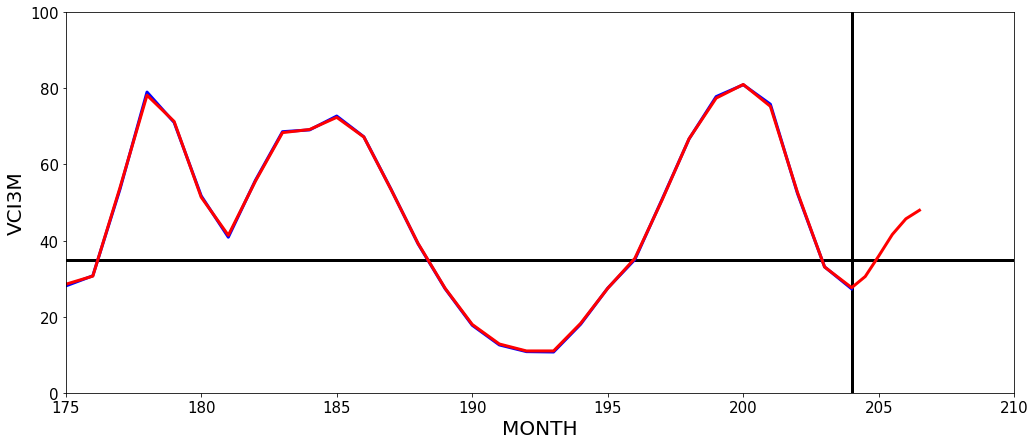

In [100]:
plt.figure(figsize=(17, 7))
plt.plot([np.max(X),np.max(X)],[0,100],color = 'black', lw = 3)
plt.plot([0,800],[35,35],color = 'black', lw = 3)

X = np.arange(np.size(M))
plt.plot(X,V, linestyle = 'solid', lw = 3, color = 'blue')
plt.plot(Xtest_use,mean, linestyle = 'solid', lw = 3, color = 'red')

plt.xlabel('MONTH', size = 20)
plt.ylabel('VCI3M', size = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(175,210)
plt.ylim(0,100)
plt.show()